### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [3]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [4]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [5]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [6]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4728)
Training epoch 20
Error tensor(0.2223)
Training epoch 40
Error tensor(0.2106)
Training epoch 60
Error tensor(0.2069)
Training epoch 80
Error tensor(0.2033)
Training epoch 100
Error tensor(0.1918)
Training epoch 120
Error tensor(0.1838)
Training epoch 140
Error tensor(0.1783)
Training epoch 160
Error tensor(0.1727)
Training epoch 180
Error tensor(0.1676)
Training epoch 200
Error tensor(0.1603)
Training epoch 220
Error tensor(0.1519)
Training epoch 240
Error tensor(0.1446)
Training epoch 260
Error tensor(0.1378)
Training epoch 280
Error tensor(0.1370)
Training epoch 300
Error tensor(0.1282)
Training epoch 320
Error tensor(0.1251)
Training epoch 340
Error tensor(0.1216)
Training epoch 360
Error tensor(0.1196)
Training epoch 380
Error tensor(0.1183)
Training epoch 400
Error tensor(0.1171)
Training epoch 420
Error tensor(0.1141)
Training epoch 440
Error tensor(0.1188)
Training epoch 460
Error tensor(0.1130)
Training epoch 480
Error tensor(0.1127)
Traini

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [7]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.019602487


### Analyzing performance of SHRED as a function of the time lag

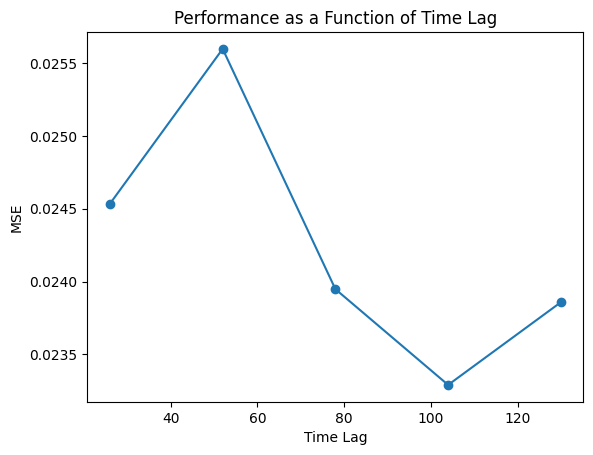

In [10]:
# Set the desired time lag values
lag_values = [26, 52, 78, 104, 130]

# Load the data
load_X = load_data('SST')

# Define other parameters
num_sensors = 3
load_size = load_X.shape[0]
sensor_locations = np.random.choice(load_X.shape[1], size=num_sensors, replace=False)
sc = MinMaxScaler()
sc = sc.fit(load_X[:, sensor_locations])  # Use only the selected sensor locations

# Initialize lists to store the performance results
mse_values = []

for lag in lag_values:
    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((load_size - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = sc.transform(load_X[i:i+lag, sensor_locations])

    # Generate datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data_in = torch.tensor(all_data_in, dtype=torch.float32).to(device)
    data_out = torch.tensor(sc.transform(load_X[lag:, sensor_locations]), dtype=torch.float32).to(device)
    dataset = TimeSeriesDataset(data_in, data_out)

    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

    # Train the SHRED model
    shred = models.SHRED(num_sensors, num_sensors, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    models.fit(shred, train_dataset.dataset, valid_dataset.dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=False)

    # Evaluate the model on the test set
    test_recons = sc.inverse_transform(shred(dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(dataset.Y.detach().cpu().numpy())
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    mse_values.append(mse)

# Plot the performance as a function of the time lag variable
plt.plot(lag_values, mse_values, marker='o')
plt.xlabel('Time Lag')
plt.ylabel('MSE')
plt.title('Performance as a Function of Time Lag')
plt.show()

### Analyzing performance of SHRED as a function of the noise level

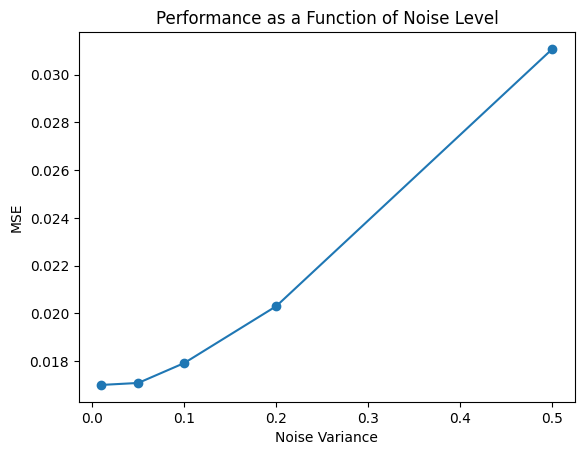

In [11]:
# Set the desired noise variance levels
noise_variances = [0.01, 0.05, 0.1, 0.2, 0.5]

# Load the data
load_X = load_data('SST')

# Define other parameters
num_sensors = 3
load_size = load_X.shape[0]
sensor_locations = np.random.choice(load_X.shape[1], size=num_sensors, replace=False)

# Initialize lists to store the performance results
mse_values = []

for noise_variance in noise_variances:
    # Generate noisy data
    noisy_load_X = load_X.copy()
    for i in range(load_X.shape[1]):
        noise = np.random.normal(0, noise_variance, load_X.shape[0])
        noisy_load_X[:, i] += noise

    # Scale the noisy data
    sc = MinMaxScaler()
    sc = sc.fit(noisy_load_X[:, sensor_locations])

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((load_size - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = sc.transform(noisy_load_X[i:i+lags, sensor_locations])

    # Generate datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data_in = torch.tensor(all_data_in, dtype=torch.float32).to(device)
    data_out = torch.tensor(sc.transform(noisy_load_X[lags:, sensor_locations]), dtype=torch.float32).to(device)
    dataset = TimeSeriesDataset(data_in, data_out)

    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

    # Train the SHRED model
    shred = models.SHRED(num_sensors, num_sensors, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    models.fit(shred, train_dataset.dataset, valid_dataset.dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=False)

    # Evaluate the model on the test set
    test_recons = sc.inverse_transform(shred(dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(dataset.Y.detach().cpu().numpy())
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    mse_values.append(mse)

# Plot the performance as a function of the noise level
plt.plot(noise_variances, mse_values, marker='o')
plt.xlabel('Noise Variance')
plt.ylabel('MSE')
plt.title('Performance as a Function of Noise Level')
plt.show()

### Analyzing performance of SHRED as a function of the number of sensors

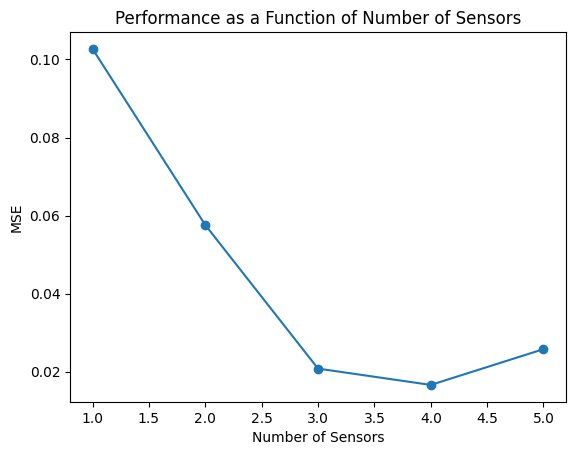

In [12]:
# Set the desired number of sensors
num_sensors_values = [1, 2, 3, 4, 5]

# Load the data
load_X = load_data('SST')

# Define other parameters
lags = 52
load_size = load_X.shape[0]
sensor_locations = np.arange(load_X.shape[1])  # All sensor locations

# Initialize lists to store the performance results
mse_values = []

for num_sensors in num_sensors_values:
    # Randomly select sensor locations
    selected_sensor_locations = np.random.choice(sensor_locations, size=num_sensors, replace=False)

    # Scale the data
    sc = MinMaxScaler()
    sc = sc.fit(load_X[:, selected_sensor_locations])

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((load_size - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = sc.transform(load_X[i:i+lags, selected_sensor_locations])

    # Generate datasets
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data_in = torch.tensor(all_data_in, dtype=torch.float32).to(device)
    data_out = torch.tensor(sc.transform(load_X[lags:, selected_sensor_locations]), dtype=torch.float32).to(device)
    dataset = TimeSeriesDataset(data_in, data_out)

    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

    # Train the SHRED model
    shred = models.SHRED(num_sensors, num_sensors, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    models.fit(shred, train_dataset.dataset, valid_dataset.dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=False)

    # Evaluate the model on the test set
    test_recons = sc.inverse_transform(shred(dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(dataset.Y.detach().cpu().numpy())
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    mse_values.append(mse)

# Plot the performance as a function of the number of sensors
plt.plot(num_sensors_values, mse_values, marker='o')
plt.xlabel('Number of Sensors')
plt.ylabel('MSE')
plt.title('Performance as a Function of Number of Sensors')
plt.show()